In [2]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from random import shuffle
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch import nn

In [3]:
caltech_dir = '/scratch/hle/101_ObjectCategories'
list_dirs = os.listdir(caltech_dir)
list_dirs.sort()
print(len(list_dirs))
list_dirs.remove('BACKGROUND_Google')


101


ValueError: list.remove(x): x not in list

In [8]:
print(list_dirs)

['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler

In [7]:
img_to_tensor = preprocess = transforms.Compose([
   transforms.Resize(100),
   transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#transforms.Normalize([0.5], [0.5])

img_data = []
for index, label in enumerate(list_dirs):
    if label != 'BACKGROUND_Google':
        label_dir = os.path.join(caltech_dir, label)
        file_names = os.listdir(label_dir)
        for f in file_names:
            img_path = os.path.join(label_dir,f)
            img = Image.open(img_path)
            img_tensor = img_to_tensor(img)
#             if img_tensor.shape[0] != 1:
#                 greyscale_img_tensor = (img_tensor[0,:,:] + img_tensor[1,:,:] + img_tensor[2,:,:]).div(3.0)
#                 img_tensor = greyscale_img_tensor.unsqueeze_(0)
            img_tensor = normalize(img_tensor)
            img_data.append({
                'label': index,
                'tensor': img_tensor
            })

shuffle(img_data)         

RuntimeError: output with shape [1, 100, 180] doesn't match the broadcast shape [3, 100, 180]

In [81]:
count = 0
for instance in img_data:
    count += 1 if instance['tensor'].shape[0] == 1 else 0
print(count)

8677


13
torch.Size([1, 100, 100])
0
torch.Size([1, 100, 100])
0
torch.Size([1, 100, 100])
3
torch.Size([1, 100, 100])
97
torch.Size([1, 100, 100])
57
torch.Size([1, 100, 100])
52
torch.Size([1, 100, 100])
47
torch.Size([1, 100, 100])
39
torch.Size([1, 100, 100])
94
torch.Size([1, 100, 100])
86
torch.Size([1, 100, 100])
29
torch.Size([1, 100, 100])
17
torch.Size([1, 100, 100])
33
torch.Size([1, 100, 100])
75
torch.Size([1, 100, 100])
84
torch.Size([1, 100, 100])


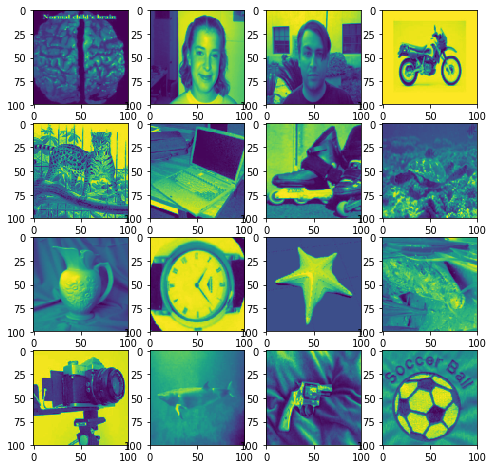

In [10]:
shuffle(img_data)

fig=plt.figure(figsize=(8, 8)) 
columns = 4 
rows = 4 
for i in range(1, columns*rows +1): 
    img = img_data[i] 
    print(img['label']) 
    print(img['tensor'].shape) 
    fig.add_subplot(rows, columns, i) 
    plt.imshow(img['tensor'][0,:,:]) 
plt.show()


In [11]:
train_size = 5554
validation_size = 1388
test_size = 1735

train_sampler = SubsetRandomSampler(np.arange(train_size, dtype=np.int64))
validation_sampler = SubsetRandomSampler(np.arange(validation_size, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(test_size, dtype=np.int64))

In [12]:
class CaltechCNN(torch.nn.Module):
    def __init__(self):
        super(CaltechCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = torch.nn.Linear(64 * 25 * 25, 256)
        
        #256 input features, 100 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(256, 101)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = self.pool1(x)
        
        print(x.shape)
        x = self.conv2(x)
        print(x.shape)
        x = F.relu(x)
        x = self.pool2(x)
        x = x.view(-1,16 * 25 * 25)
        
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return(x)
        

In [18]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=101, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

In [13]:
def createLossAndOptimizer(net, learning_rate=0.001):
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return loss, optimizer

shuffle(img_data)

In [14]:
#  spliting data, create the data loader
data_splitted = {}
data_splitted['train'], data_splitted['val'], data_splitted['test'] = random_split(img_data, (train_size, validation_size, test_size))
loader = {'train': DataLoader(data_splitted['train'], batch_size=32),
          'val': DataLoader(data_splitted['val']),
          'test': DataLoader(data_splitted['test'])}

In [16]:
# train_set = img_data[:train_size]
# validation_size = img_data[train_size:train_size + validation_size]
# test_size = img_data[train_size + validation_size:]
SAVE_PATH = '/scratch/hle/data/trained_models/caltech101/'

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = loader['train']
    val_loader = loader['val']
    test_loader = loader['test']
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 2
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader):
            #Get inputs
            inputs = data['tensor']
            labels = data['label']
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs).cuda(1), Variable(labels).cuda(1)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
#             print(i)
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.item()
            total_train_loss += loss_size.item()
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        correct = 0
        for i, data in enumerate(val_loader):
            #Wrap tensors in Variables
            inputs = data['tensor']
            labels = data['label']
            inputs, labels = Variable(inputs).cuda(1), Variable(labels).cuda(1)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.item()
            
            _, predicted = torch.max(val_outputs.data, 1)
            correct += (predicted == labels).sum().item()
            
        if (epoch+1) % 15 == 0:
            torch.save(net.state_dict(), os.path.join(SAVE_PATH, 'caltech101_spp_%s' %(epoch+1)))
            
        print("Validation loss = {:.2f} accuracy = {:.2f}".format(total_val_loss / len(val_loader), correct/len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [17]:
CNN = CaltechCNN()
CNN.cuda(1)
trainNet(CNN, batch_size=32, n_epochs=50, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 50
learning_rate= 0.001
torch.Size([32, 32, 50, 50])
torch.Size([32, 64, 50, 50])


RuntimeError: size mismatch, m1: [128 x 10000], m2: [40000 x 256] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:266

In [70]:
net = SPP_NET()
net.load_state_dict(torch.load(os.path.join(SAVE_PATH, 'caltech101_15')))
net.eval()

correct = 0
total = 0
test_loader = loader['test']

fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
# for i in range(1, columns*rows +1):
#     img = img_data[i]
#     print(img['label'])
#     print(img['tensor'].shape)
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img['tensor'][0,:,:])
# plt.show()

with torch.no_grad():
    for i, data in enumerate(test_loader):
#         if i >= 16:
#             break
        inputs = data['tensor']
        labels = data['label']
        inputs, labels = Variable(inputs).cuda(1), Variable(labels).cuda(1)
        outputs = CNN(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += 1 if (predicted.item() == labels.item()) else 0
        
#         fig.add_subplot(rows, columns, i+1)
#         plt.imshow(inputs.cpu()[0,0,:,:])
#         print("true label: %s" % list_dirs[labels.item()])
#         print("predicted label: %s" % list_dirs[predicted.item()])

print(total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
plt.show()

1735
Accuracy of the network on the 10000 test images: 45 %


In [ ]:
from torchvision